In [31]:
import pandas as pd
import numpy as np
from itertools import groupby
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import cluster,mixture
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import scipy
from pandas.core.common import flatten

Idea:
blank removal --> noise removal --> find unique/shared clusters --> use information for id --> use information for tracking
```
sudo code:
picking up sources
output labeled table
use the information for the source id

two way:
1. venn diagram --> source id
2. more data: single source approach to identify clusters for different sources and use the modeling approach for source tracking
```

important : tweak the parameters during venn diagram approach

Two ways: use source data + venn diagram, give unique cluster higher score and shared cluster lower score, given a new sample, can predict the source id, or assign with possibility scores, for instance >70% of cluster features present then the shource exists. Hard to do source tracking since matrix effect and dilution effect is not considered

better way with more data: every source with dilution series, and use the single source approach to find clusters, and modeling for the source approportioning



In [2]:
d_ms = pd.read_csv('../example_data/clustering/sample1114.csv')
d_ms = d_ms.rename(columns={'Average Rt(min)': 'Average RT (min)', 'Average Mz': 'Average m/z', 'S/N average': 'Average sn'})
d_ms.insert(3, "Average score", 1)

In [81]:
def data_prep(d_input, blank_keyword, svb_thres=10, empty_thres=0, cv_thres=3,rt_range=[0, 30], mz_range=[0, 1200], sn_thres=3, score_thres=0, area_thres=5000):
    '''
    The function is used to clean the dataframe according to user setting
    blank_keyword: part of string from column that indicates the column is a blank sample
    svb_thres: sample vs blank thres
    empty_thres: empty cell thres in a row
    cv_thres: as all sample is in triplicate, calculate the CV for every triplicate sample set #Needs to be updated in case there is no triplicate samples
    rt_range: rt filter
    mz_range: mz filter
    sn_thres: signal/noise column thres
    score_thres: score column thres
    area_thres: count for max peak area from each row
    '''
    d_thres = d_input[d_input[d_input.columns[4:]].max(1) >= area_thres]
    
    d_thres = d_thres[(d_thres['Average RT (min)'] > rt_range[0]) & (d_thres['Average RT (min)'] < rt_range[1])]
    d_thres = d_thres[(d_thres['Average m/z'] > mz_range[0]) & (d_thres['Average m/z'] < mz_range[1])]
    d_thres = d_thres[d_thres['Average sn'] >= sn_thres]
    d_thres = d_thres[d_thres['Average score'] >= score_thres]
    d_thres.reset_index(inplace=True, drop=True)
    
    col_blank = []
    for key in blank_keyword:
        # Get column name if it contains blank indicating strings
        col_blank.extend([col for col in d_thres.columns if key in col])
        
    col_sample = [col for col in d_thres.columns if col not in col_blank]
    # Sample maximum area vs Blank average area to count for svb
    d_sample = d_thres[d_thres[col_sample[4:]].max(axis=1) / d_thres[col_blank].mean(axis=1) > svb_thres][col_sample] 
    d_sample.reset_index(inplace=True)
    d_sample.drop(columns=['index'],inplace=True)
    
    # Get a list of triplicate, every triplicate is in a sublist
    #Sample: [[a1,a2,a3],[b1,b2,b3]]
    #Note: the triplicate parsing is now only used '_' which needs update in the future
    trip_list = [list(i) for j, i in groupby(d_sample.columns[4:], lambda a: a.split('_')[:-1])] 
    trip_list = [i for i in trip_list if len(i)>=2] #filter out columns that is not in triplicate -- sample naming issue

    for triplicate in tqdm(trip_list):
        # DM: maybe use iterrtuples? iterrows has low efficiency and is not reccomended 
        for row in d_sample[triplicate].itertuples(): # Loop for every sets of triplicates
            if row[1:].count(0) > empty_thres:
                d_sample.loc[row.Index, triplicate] = 0 # if more than thres, then set all three values to 0
            elif np.mean(row[1:]) != 0:
                if np.std(row[1:]) / np.mean(row[1:]) > cv_thres:
                    d_sample.loc[row.Index, triplicate] = 0 #need verify, not work for now
            else:
                pass
            
    d_sample = d_sample[~(d_sample[d_sample.columns[4:]]==0).all(1)] #clean rows with all 0
    
    return d_sample

In [62]:
keys=['CEC','Blank','ISTD','Wash','Shutdown']
d_sample = data_prep(d_ms,keys,rt_range = [1,30], mz_range = [200,800], area_thres=500)

100%|██████████| 35/35 [02:04<00:00,  3.57s/it]


1. grouping
2. noise_rm & filter
3. source ID using avg PAs -- consider the score or other labels in the source label?
4. calc dilution as below -- score?

In [133]:
def source_label(d_input, sourcelist,area_thres=5000): #noise removal only based on sourcelist cols
    np.seterr(divide='ignore', invalid='ignore')
    #source labeling
    d_result = d_input.copy()
    source_col=[]
    for s in sourcelist:
        source = [col for col in d_input.columns if s in col]
        source_col.append(source)
    simp_dict={}
    for i, column in enumerate(source_col):
        avg = d_result[column].mean(1)
        cv = d_result[column].std(1) / d_result[column].mean(1) #optional display CV
        simp_dict.update({sourcelist[i]:avg})
    d_summary = pd.DataFrame(simp_dict)
    d_summary['source']="NA"
    for row in d_summary.itertuples():
        sourcelabel = list(d_summary.columns[[col_index for col_index, peak_avg in enumerate(row[1:-1]) if peak_avg >= area_thres]])
        if len(sourcelabel) != 0:
            labelstr = ','.join(sourcelabel)
            d_summary.at[row.Index,'source'] = labelstr
    d_result['source'] = d_summary['source']
    
    return d_result, d_summary

In [304]:
sourcelist=['Coulter','Crescent','Miller','Swan','SR520-Cal-in-DI_1000mL'] #Needs adjustment
d_label, d_simp = source_label(d_sample,sourcelist,area_thres= 50000)

In [ ]:
#User case for coverage score

In [253]:
mix_key = ['Mix']
thres = 1000
source_key = 'SR520-Cal-in-DI_1000mL'
method='multiple'

result = []
for key in mix_key:
    mix_col.extend([col for col in d_label.columns if key in col])
for col in mix_col:
    cov_score = sum(d_label[d_label[col] >= thres]['source'].str.contains(source_key)) / sum(d_label['source'].str.contains(source_key))
    if method == 'single':
        mix = d_label[d_label['source'] == source_key][col]
        s_simp = d_simp[d_simp['source'] == source_key][source_key]
    elif method == 'multiple':
        mix = d_label[d_label['source'].str.contains(source_key)][col]
        s_simp = d_simp.loc[d_label[d_label['source'].str.contains(source_key)].index][source_key]
    match_index = [i for i, j in enumerate(mix) if j >= thres]
    dilu = mix.iloc[match_index] / s_simp.iloc[match_index]
    ratio_score = np.average(dilu[dilu<1])
    result.append([col, cov_score, ratio_score])
    d_st = pd.DataFrame(result, columns = ['sample', 'cov_score', 'ratio_score'])

visualization based on single sample

chart based on all 

|sample name|feature from source1|coverage score source1|etc2|etc2|
|---|---|---|---|---|
|sample1|1800|0.3|2000|0.5|
|sample2|a|b|c|d|

[289, 282, 1982, 272, 820]


([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

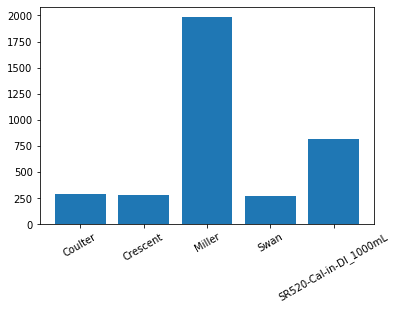

In [305]:
graph_list = []
for s in sourcelist:
    graph_list.append(sum(d_label[d_label['20181114_SR520-Creek_Mix4A_3'] >= 1000]['source'].str.contains(s)))
print(graph_list)
plt.bar(sourcelist,graph_list)
plt.xticks(rotation=30)#?? double check column names and if sample goes right
#Next: apply the function on all mix sample and create chart like above

first --> assign label to different features

second --> ID using the features

third --> assessment, for instance, final ID confidence = 50% feature quantity score + 50% feature intensity score

sample A have 50% of source A feature, avg intensity ratio(5~95%) is 90%, then score = $0.5*0.5(feature #)+0.5*0.9$ (major feature intensity)

for approportioning calculation --> matrix effect needs to be overcome --> more samples and data needed and will be a long term dev & validation process